In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 

# File paths
data_dir = "./data"

# Loading data 
data_file = ["credit_card_scaled_and_cleaned.csv", "balanced_credit_card.csv", "semi_balanced_credit_card.csv"]
file_path = os.path.join(data_dir, data_file[0])
df = pd.read_csv(file_path, header=0)

file_path = os.path.join(data_dir, data_file[1])
balanced_df = pd.read_csv(file_path, header=0)

file_path = os.path.join(data_dir, data_file[2])
semi_balanced_df = pd.read_csv(file_path, header=0)

### Modeling:

In [2]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

Split the Data into Training and Testing Sets
Separate the Class attribute (target) from the rest of the features, and split the datasets into training and testing sets

In [3]:
# Split unbalanced dataset
X_unbalanced = df.drop('Class', axis=1)
y_unbalanced = df['Class']

X_train_unbalanced, X_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(
    X_unbalanced, y_unbalanced, test_size=0.3, stratify=y_unbalanced, random_state=42
)

In [4]:
# Split balanced dataset
X_balanced = balanced_df.drop('Class', axis=1)
y_balanced = balanced_df['Class']

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42
)


In [5]:
# Split semi balanced dataset
X_semi_balanced = semi_balanced_df.drop('Class', axis=1)
y_semi_balanced = semi_balanced_df['Class']

X_train_semi_balanced, X_test_semi_balanced, y_train_semi_balanced, y_test_semi_balanced = train_test_split(
    X_semi_balanced, y_semi_balanced, test_size=0.3, stratify=y_semi_balanced, random_state=42
)

#### Logistic Regression:

In [6]:
from sklearn.linear_model import LogisticRegression

# Define Logistic Regression model and parameters
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_params = {
    'C': [0.01, 0.1, 1, 10],        # Regularization strength
    'penalty': ['l1', 'l2'],        # Type of regularization
    'solver': ['liblinear']         # Solver that supports L1 and L2
}


### SVM:

In [7]:
from sklearn.svm import SVC

# Define SVM model and parameters
svm_model = SVC(probability=True, random_state=42)  # Enable probability=True for ROC AUC
svm_params = {
    'C': [0.1, 1, 10],             # Regularization strength
    'kernel': ['linear', 'rbf'],   # Kernel type
    'gamma': ['scale', 'auto']     # Kernel coefficient
}


### Random Forest:

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Define Random Forest model and parameters
rf_model = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [50, 100, 200],   # Number of trees
    'max_depth': [None, 10, 20],      # Maximum depth of each tree
    'min_samples_split': [2, 5],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2]        # Minimum samples in a leaf node
}


### Defining Scoring Metrics:

In [9]:

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, response_method='predict_proba')
}


#### Define Stratified K-Fold cross-validator:

In [10]:
## Are these just trained for generally best params or are they trained to have the best params for the data? 
## I feel like we should attempt to train these for our dataset(s) specifically if (if they arent already) so as to get the best results.
## I don't think it's too big a deal though, Our current models are pretty alright (I think)

def train_with_kfold(model, params, model_name, X_train, y_train):
    grid = GridSearchCV(
        model,
        params,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=scoring,
        refit='accuracy',
        verbose=1
    )
    
    #grid.fit(X_train_balanced, y_train_balanced)
    grid.fit(X_train, y_train)
    
    # Extract cross-validation results
    cv_results = grid.cv_results_
    improvements = []

    print(f"\n{model_name} Cross-Validation Results:")
    print(f"Best Parameters: {grid.best_params_}")

    # Calculate improvements for each metric
    for metric in scoring.keys():
        metric_scores = cv_results[f'mean_test_{metric}']
        top_score = metric_scores.max()
        lowest_score = metric_scores.min()
        improvements.append({
            "Metric": metric.capitalize(),
            "Top Score": top_score,
            "Lowest Score": lowest_score,
            "Difference": top_score - lowest_score
        })
        print(f"{metric.capitalize()}: Top={top_score:.4f}, Lowest={lowest_score:.4f}, Difference={top_score - lowest_score:.4f}")
    
    # Return the trained model and improvements
    return grid.best_estimator_, pd.DataFrame(improvements)

# Train each model on with each dataset
best_lr_balanced, lr_improvements_balanced = train_with_kfold(lr_model, lr_params, "Logistic Regression", X_train_balanced, y_train_balanced)
best_svm_balanced, svm_improvements_balanced = train_with_kfold(svm_model, svm_params, "Support Vector Machine (SVM)", X_train_balanced, y_train_balanced)
best_rf_balanced, rf_improvements_balanced = train_with_kfold(rf_model, rf_params, "Random Forest", X_train_balanced, y_train_balanced)

# Can't really train directly with this data, It was running for 30 minutes and only got through the logistic regression

#best_lr_unbalanced, lr_improvements_unbalanced = train_with_kfold(lr_model, lr_params, "Logistic Regression", X_train_unbalanced, y_train_unbalanced)
#best_svm_unbalanced, svm_improvements_unbalanced = train_with_kfold(svm_model, svm_params, "Support Vector Machine (SVM)", X_train_unbalanced, y_train_unbalanced)
#best_rf_unbalanced, rf_improvements_unbalanced = train_with_kfold(rf_model, rf_params, "Random Forest", X_train_unbalanced, y_train_unbalanced)

best_lr_semi_balanced, lr_improvements_semi_balanced = train_with_kfold(lr_model, lr_params, "Logistic Regression", X_train_semi_balanced, y_train_semi_balanced)
best_svm_semi_balanced, svm_improvements_semi_balanced = train_with_kfold(svm_model, svm_params, "Support Vector Machine (SVM)", X_train_semi_balanced, y_train_semi_balanced)
best_rf_semi_balanced, rf_improvements_semi_balanced = train_with_kfold(rf_model, rf_params, "Random Forest", X_train_semi_balanced, y_train_semi_balanced)


Fitting 5 folds for each of 8 candidates, totalling 40 fits

Logistic Regression Cross-Validation Results:
Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: Top=0.9433, Lowest=0.7820, Difference=0.1614
Precision: Top=0.9781, Lowest=0.7085, Difference=0.2696
Recall: Top=0.9594, Lowest=0.9012, Difference=0.0582
F1: Top=0.9416, Lowest=0.8148, Difference=0.1268
Roc_auc: Top=0.9852, Lowest=0.9637, Difference=0.0214
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Support Vector Machine (SVM) Cross-Validation Results:
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: Top=0.9462, Lowest=0.9128, Difference=0.0335
Precision: Top=0.9902, Lowest=0.9039, Difference=0.0863
Recall: Top=0.9302, Lowest=0.8460, Difference=0.0843
F1: Top=0.9437, Lowest=0.9115, Difference=0.0322
Roc_auc: Top=0.9825, Lowest=0.9666, Difference=0.0159
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Random Forest Cross-Validation Results:
Best Parame

### Cross-Validation Improvements Table:

In [11]:
print("\nCross-Validation Improvements, Balanced dataset:")
print("Logistic Regression Improvements:\n", lr_improvements_balanced)
print("SVM Improvements:\n", svm_improvements_balanced)
print("Random Forest Improvements:\n", rf_improvements_balanced)
#print("-"*40)
#print("\nCross-Validation Improvements, Original, Unbalanced dataset:")
#print("Logistic Regression Improvements:\n", lr_improvements_unbalanced)
#print("SVM Improvements:\n", svm_improvements_unbalanced)
#print("Random Forest Improvements:\n", rf_improvements_unbalanced)
print("-"*50)
print("\nCross-Validation Improvements, Semi-Balanced dataset:")
print("Logistic Regression Improvements:\n", lr_improvements_semi_balanced)
print("SVM Improvements:\n", svm_improvements_semi_balanced)
print("Random Forest Improvements:\n", rf_improvements_semi_balanced)


Cross-Validation Improvements, Balanced dataset:
Logistic Regression Improvements:
       Metric  Top Score  Lowest Score  Difference
0   Accuracy   0.943330      0.781974    0.161356
1  Precision   0.978102      0.708533    0.269568
2     Recall   0.959378      0.901151    0.058227
3         F1   0.941632      0.814850    0.126782
4    Roc_auc   0.985169      0.963721    0.021448
SVM Improvements:
       Metric  Top Score  Lowest Score  Difference
0   Accuracy   0.946250      0.912779    0.033471
1  Precision   0.990206      0.903868    0.086339
2     Recall   0.930222      0.845951    0.084271
3         F1   0.943685      0.911489    0.032196
4    Roc_auc   0.982480      0.966610    0.015870
Random Forest Improvements:
       Metric  Top Score  Lowest Score  Difference
0   Accuracy   0.937544      0.930276    0.007268
1  Precision   0.977894      0.968325    0.009569
2     Recall   0.895354      0.889557    0.005797
3         F1   0.934498      0.926919    0.007580
4    Roc_auc   0.

### Create Function to Test Models on the Balanced Dataset:


In [12]:
## If we intend to implement more graphing and visualizations later on, like with a confusion matrix or roc curves, this code (and all other model testing code chunks) will likely have to be modified

def evaluate_on_balanced(model, model_name):
    y_pred = model.predict(X_test_balanced)
    y_proba = model.predict_proba(X_test_balanced)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test_balanced, y_pred)
    precision = precision_score(y_test_balanced, y_pred)
    recall = recall_score(y_test_balanced, y_pred)
    f1 = f1_score(y_test_balanced, y_pred)
    roc_auc = roc_auc_score(y_test_balanced, y_proba) if y_proba is not None else "N/A"

    # Additional variables
    confusion_matrix_ = confusion_matrix(y_test_balanced, y_pred)
    roc_curve_data = roc_curve(y_test_balanced, y_proba) if y_proba is not None else None


    return model_name, accuracy, precision, recall, f1, roc_auc, confusion_matrix_, roc_curve_data


### Create Function to Test Models on the Original Dataset:

In [13]:
def evaluate_on_original(model, model_name):
    y_pred = model.predict(X_test_unbalanced)
    y_proba = model.predict_proba(X_test_unbalanced)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test_unbalanced, y_pred)
    precision = precision_score(y_test_unbalanced, y_pred)
    recall = recall_score(y_test_unbalanced, y_pred)
    f1 = f1_score(y_test_unbalanced, y_pred)
    roc_auc = roc_auc_score(y_test_unbalanced, y_proba) if y_proba is not None else "N/A"

    # Additional variables
    confusion_matrix_ = confusion_matrix(y_test_unbalanced, y_pred)
    roc_curve_data = roc_curve(y_test_unbalanced, y_proba) if y_proba is not None else None


    return model_name, accuracy, precision, recall, f1, roc_auc, confusion_matrix_, roc_curve_data



### Create Function to Test Models on the Semi Balanced Dataset:

In [14]:
def evaluate_on_semi_balanced(model, model_name):
    y_pred = model.predict(X_test_semi_balanced)
    y_proba = model.predict_proba(X_test_semi_balanced)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test_semi_balanced, y_pred)
    precision = precision_score(y_test_semi_balanced, y_pred)
    recall = recall_score(y_test_semi_balanced, y_pred)
    f1 = f1_score(y_test_semi_balanced, y_pred)
    roc_auc = roc_auc_score(y_test_semi_balanced, y_proba) if y_proba is not None else "N/A"

    # Additional variables
    confusion_matrix_ = confusion_matrix(y_test_semi_balanced, y_pred)
    roc_curve_data = roc_curve(y_test_semi_balanced, y_proba) if y_proba is not None else None


    return model_name, accuracy, precision, recall, f1, roc_auc, confusion_matrix_, roc_curve_data


# Running Models on all datasets:

### Test All Models on the Balanced Dataset:


In [30]:
# Evaluate models on balanced test set with balanced optimized Models
balanced_results = []
CMs_balanced = []
roc_curves_balanced = []

for model, name in [(best_lr_balanced, "Logistic Regression"), (best_svm_balanced, "SVM"), (best_rf_balanced, "Random Forest")]:
    result = evaluate_on_balanced(model, name)
    balanced_results.append(result[:6])  # Include only the first six values in the DataFrame
    CMs_balanced.append(result[6])    # Store additional variables separately
    roc_curves_balanced.append((name, result[7]))  # Store ROC curve data separately

# Evaluate models on balanced test set with alternative semi-balanced optimized Models
balanced_results_smodels = []
CMs_balanced_smodels = []
roc_curves_balanced_smodels = []

for model, name in [(best_lr_semi_balanced, "Logistic Regression"), (best_svm_semi_balanced, "SVM"), (best_rf_semi_balanced, "Random Forest")]:
    result = evaluate_on_balanced(model, name)
    balanced_results_smodels.append(result[:6])  # Include only the first six values in the DataFrame
    CMs_balanced_smodels.append(result[6])    # Store additional variables separately
    roc_curves_balanced_smodels.append((name, result[7]))  # Store ROC curve data separately

### Test All Models on the Original Data set:

In [16]:
# Evaluate models on unbalanced test set with balanced optimized Models
unbalanced_results = []
CMs_unbalanced = []
roc_curves_unbalanced = []

for model, name in [(best_lr_balanced, "Logistic Regression"), (best_svm_balanced, "SVM"), (best_rf_balanced, "Random Forest")]:
    result = evaluate_on_original(model, name)
    unbalanced_results.append(result[:6])  # Include only the first six values in the DataFrame
    CMs_unbalanced.append(result[6])    # Store additional variables separately
    roc_curves_unbalanced.append((name, result[7]))  # Store ROC curve data separately

# Evaluate models on unbalanced test set with alternative semi-balanced optimized Models
unbalanced_results_smodels = []
CMs_unbalanced_smodels = []
roc_curves_unbalanced_smodels = []

for model, name in [(best_lr_semi_balanced, "Logistic Regression"), (best_svm_semi_balanced, "SVM"), (best_rf_semi_balanced, "Random Forest")]:
    result = evaluate_on_original(model, name)
    unbalanced_results_smodels.append(result[:6])  # Include only the first six values in the DataFrame
    CMs_unbalanced_smodels.append(result[6])    # Store additional variables separately
    roc_curves_unbalanced_smodels.append((name, result[7]))  # Store ROC curve data separately

### Test All Models on the Semi-Balanced Dataset:

In [17]:
# Evaluate models on unbalanced test set with balanced optimized Models
semi_balanced_results = []
CMs_semi_balanced = []
roc_curves_semi_balanced = []

for model, name in [(best_lr_balanced, "Logistic Regression"), (best_svm_balanced, "SVM"), (best_rf_balanced, "Random Forest")]:
    result = evaluate_on_semi_balanced(model, name)
    semi_balanced_results.append(result[:6])  # Include only the first six values in the DataFrame
    CMs_semi_balanced.append(result[6])    # Store additional variables separately
    roc_curves_semi_balanced.append((name, result[7]))  # Store ROC curve data separately

# Evaluate models on unbalanced test set with alternative semi-balanced optimized Models
semi_balanced_results_smodels = []
CMs_semi_balanced_smodels = []
roc_curves_semi_balanced_smodels = []

for model, name in [(best_lr_semi_balanced, "Logistic Regression"), (best_svm_semi_balanced, "SVM"), (best_rf_semi_balanced, "Random Forest")]:
    result = evaluate_on_semi_balanced(model, name)
    semi_balanced_results_smodels.append(result[:6])  # Include only the first six values in the DataFrame
    CMs_semi_balanced_smodels.append(result[6])    # Store additional variables separately
    roc_curves_semi_balanced_smodels.append((name, result[7]))  # Store ROC curve data separately

### Output results to Dataframes for easy viewing and numerical comparison

In [25]:
## Printing the results data frame of the semi_balanced data and other data sets for easier comparison

balanced_results_df = pd.DataFrame(balanced_results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])
print("\nEvaluation on Balanced Dataset's Test Set:")
print(balanced_results_df)
print("-"*74)
original_results_df = pd.DataFrame(unbalanced_results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])
print("\nEvaluation on Original Dataset:")
print(original_results_df)
print("-"*74)
semi_balanced_results_df = pd.DataFrame(semi_balanced_results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])
print("\nEvaluation on Semi Balanced Dataset's Test Set:")
print(semi_balanced_results_df)
print()
print("Below are The results of running the models with parameters optimized for the semi_balanced dataset on each dataset")
print()
balanced_results_smodels_df = pd.DataFrame(balanced_results_smodels, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])
print("\nEvaluation on Balanced Dataset's Test Set:")
print(balanced_results_smodels_df)
print("-"*74)
original_results_smodels_df = pd.DataFrame(unbalanced_results_smodels, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])
print("\nEvaluation on Original Dataset:")
print(original_results_smodels_df)
print("-"*74)
semi_balanced_results_smodels_df = pd.DataFrame(semi_balanced_results_smodels, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])
print("\nEvaluation on Semi Balanced Dataset's Test Set:")
print(semi_balanced_results_smodels_df)


Evaluation on Balanced Dataset's Test Set:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.932432   0.944444  0.918919  0.931507  0.970645
1                  SVM  0.932432   0.970588  0.891892  0.929577  0.981602
2        Random Forest  0.935811   0.964029  0.905405  0.933798  0.971398
--------------------------------------------------------------------------

Evaluation on Original Dataset:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.960278   0.037607  0.891892  0.072171  0.978262
1                  SVM  0.975504   0.058957  0.878378  0.110497  0.980443
2        Random Forest  0.966867   0.047555  0.952703  0.090588  0.988528
--------------------------------------------------------------------------

Evaluation on Semi Balanced Dataset's Test Set:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.943567   0.948905  0.878378  0.9

### Analysis:

While the models tested on the Original dataset generally gave better Accuracy and Recall results, their precision and F1 score results were notably VERY bad. On the other hand The models trained on the Balanced Set yielded more balanced results, with worse scores in every catagory except precision and F1, where they outperformed the models trained on the original dataset. These results, however, are realistically to be expected. We knew from the beginning that, due to the extreme imbalance in the dataset, ROC AUC would end up being a far better measure off model quality than confusion matrix metrics.

In general, it was found that the models optimized for the Balanced dataset yielded the best overall results. For our project, we valued Recall and ROC AUC over all other metrics and in almost every case, The models optimized for the Balaned dataset yielded higher scores in these two metrics

In most cases, the Random Forest Algorithm yielded the highest Recall and ROC AUC Scores which was a somewhat expected result given the sophistication of the Random Forest Algorithm in comparison to the other 2 Algorithms we tested.


## Plot all confusion matrices to clearly show Recall of different models on different datasets:

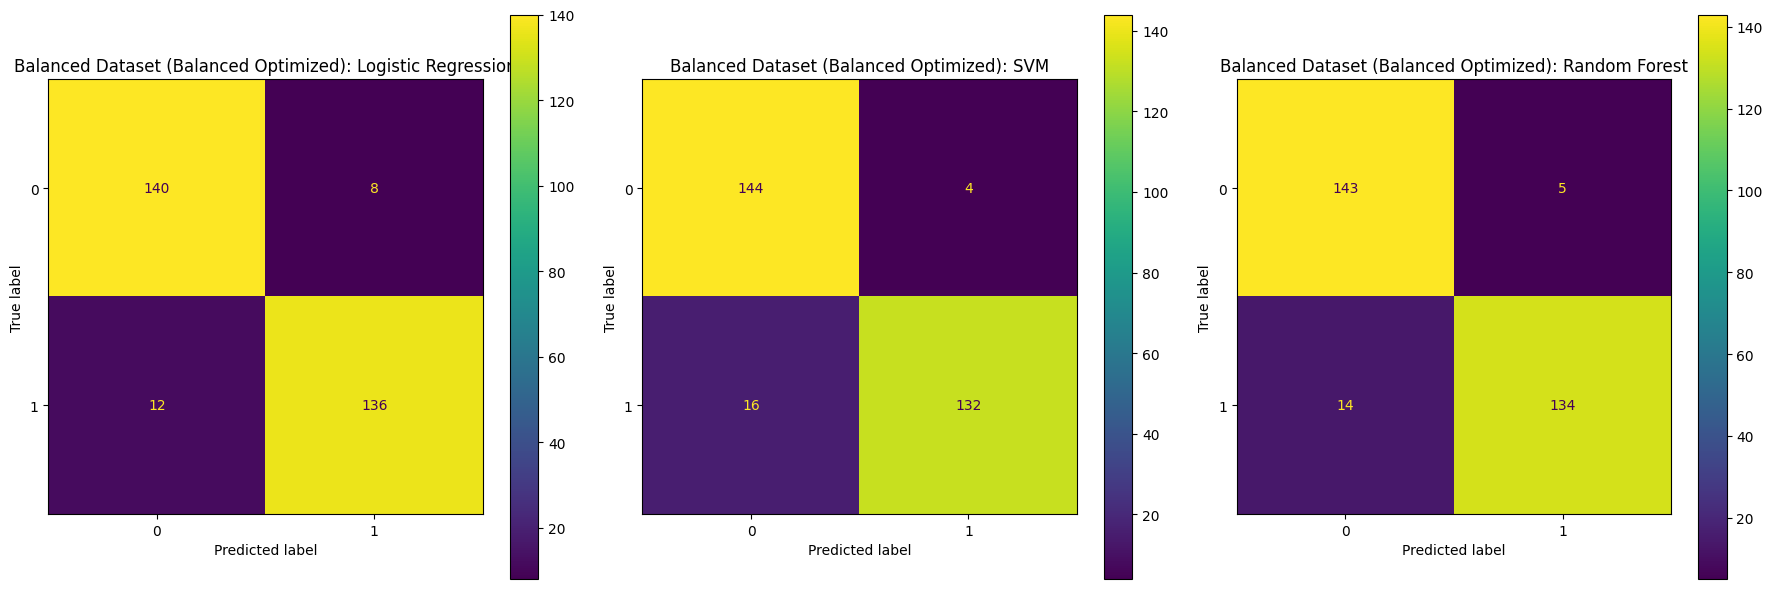

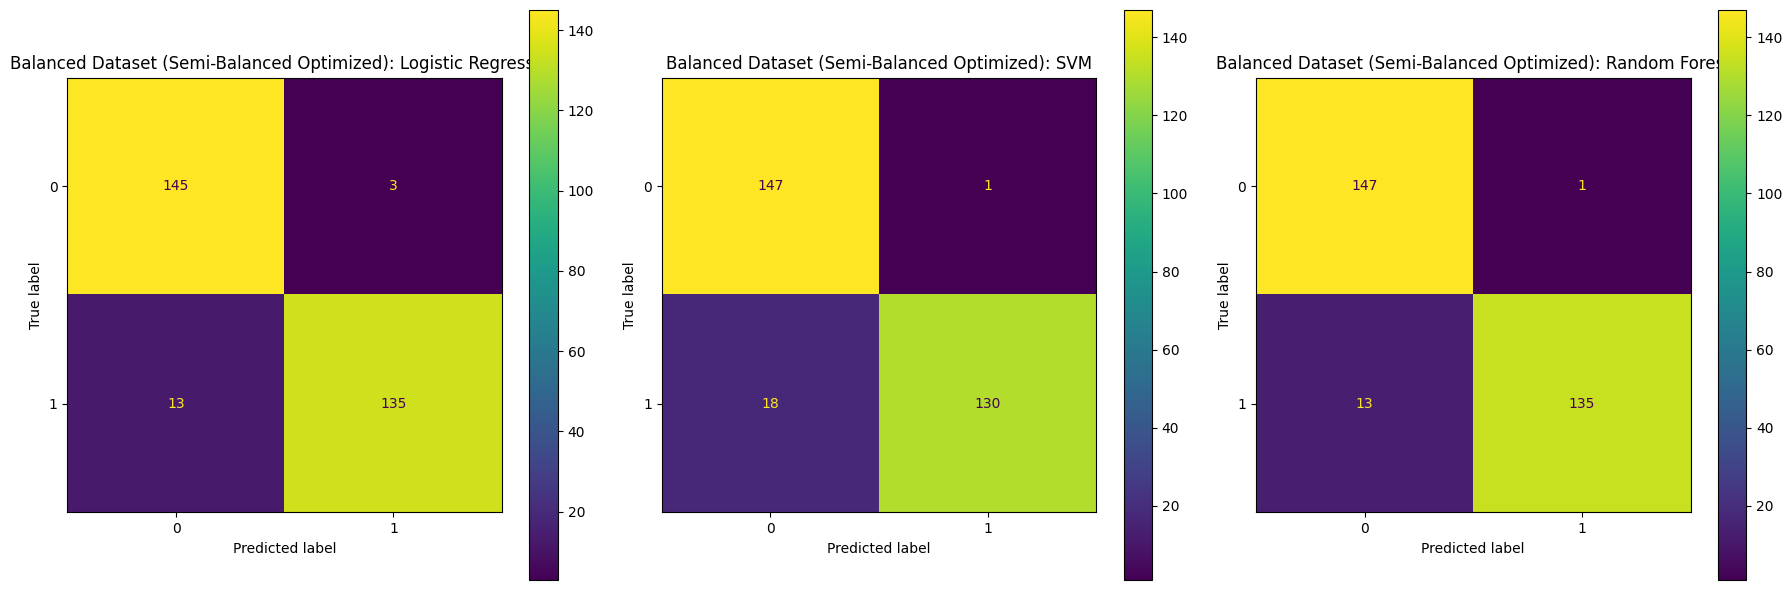

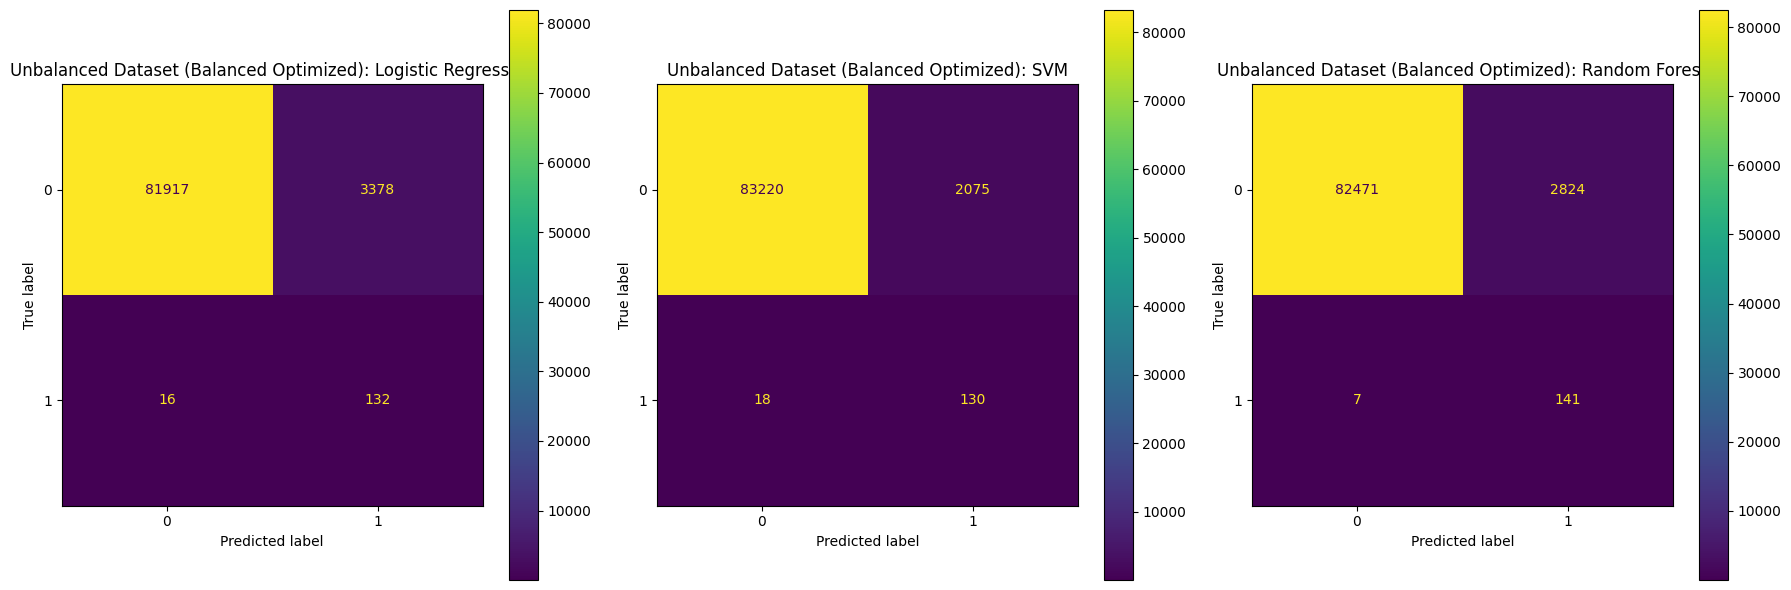

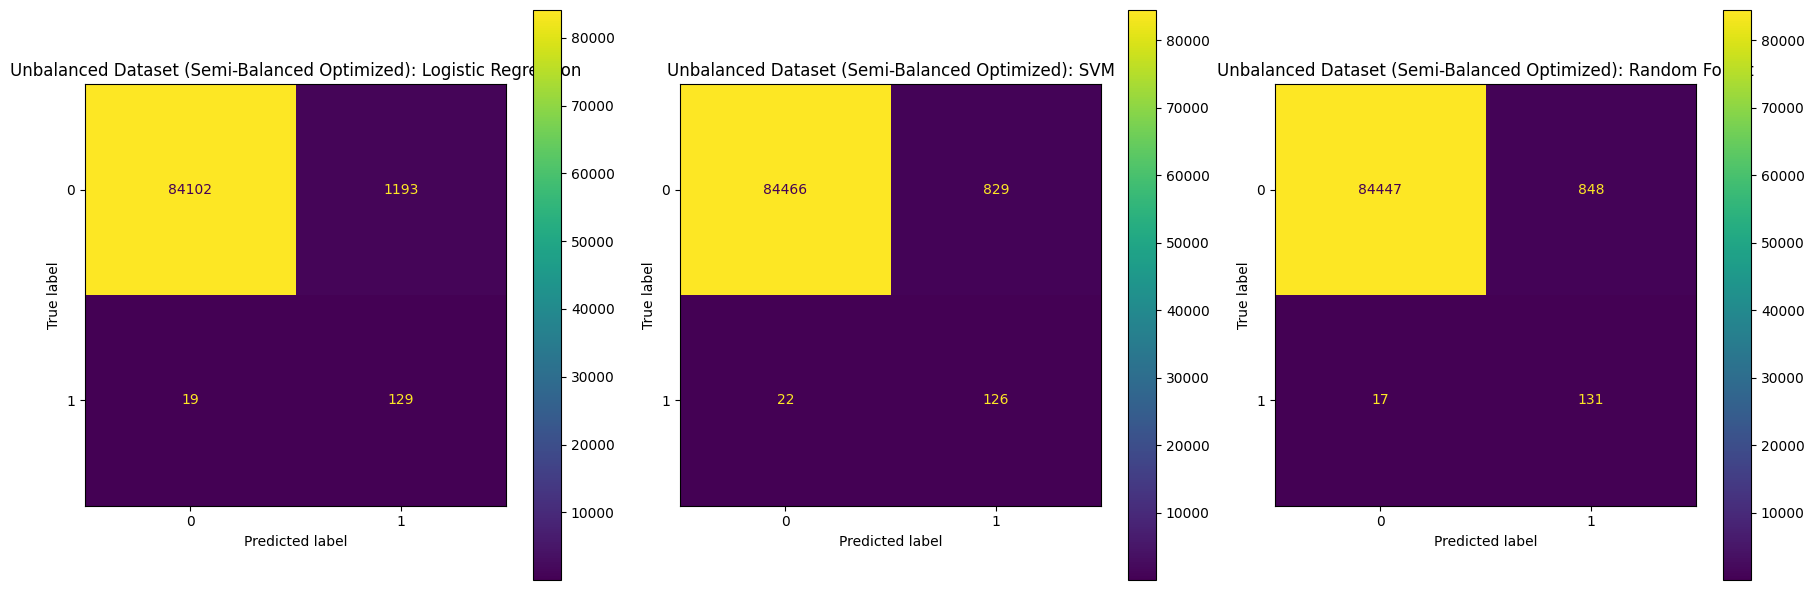

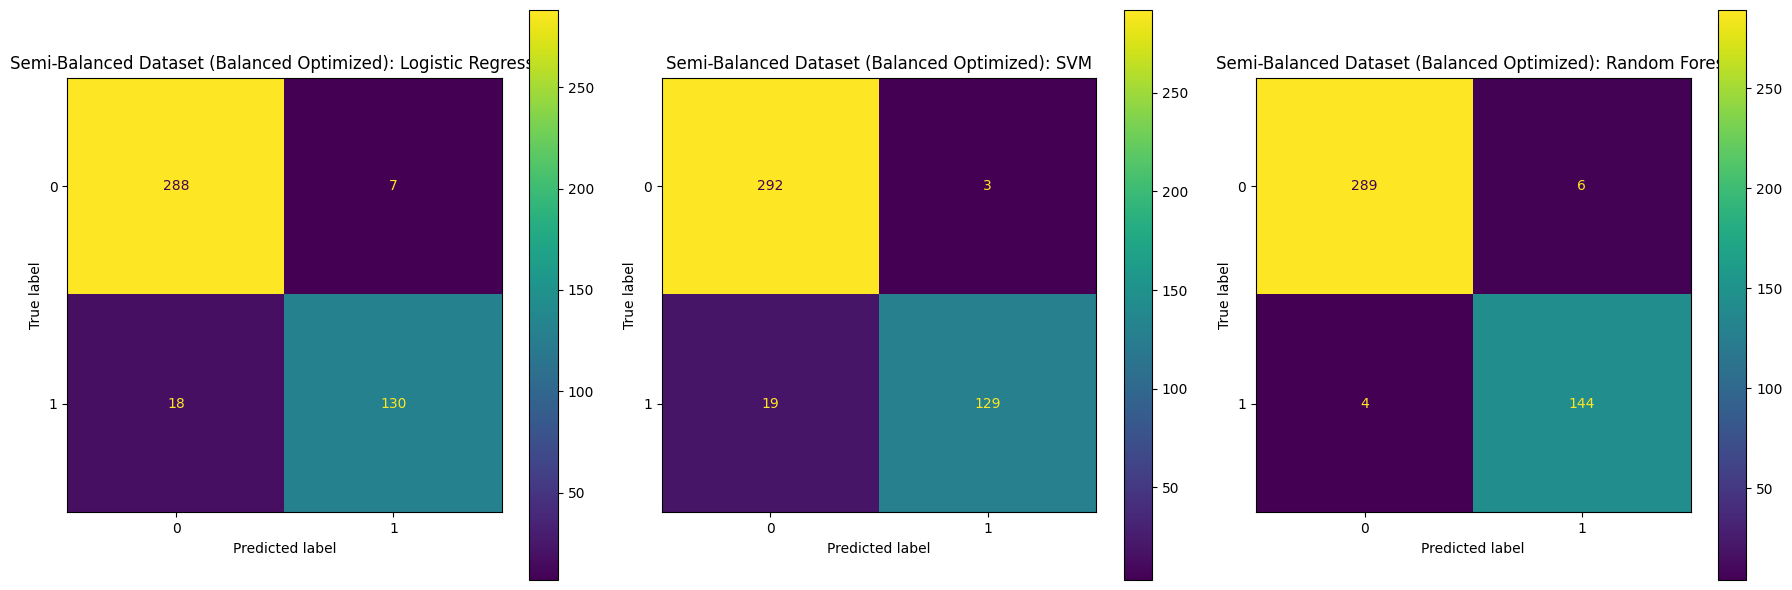

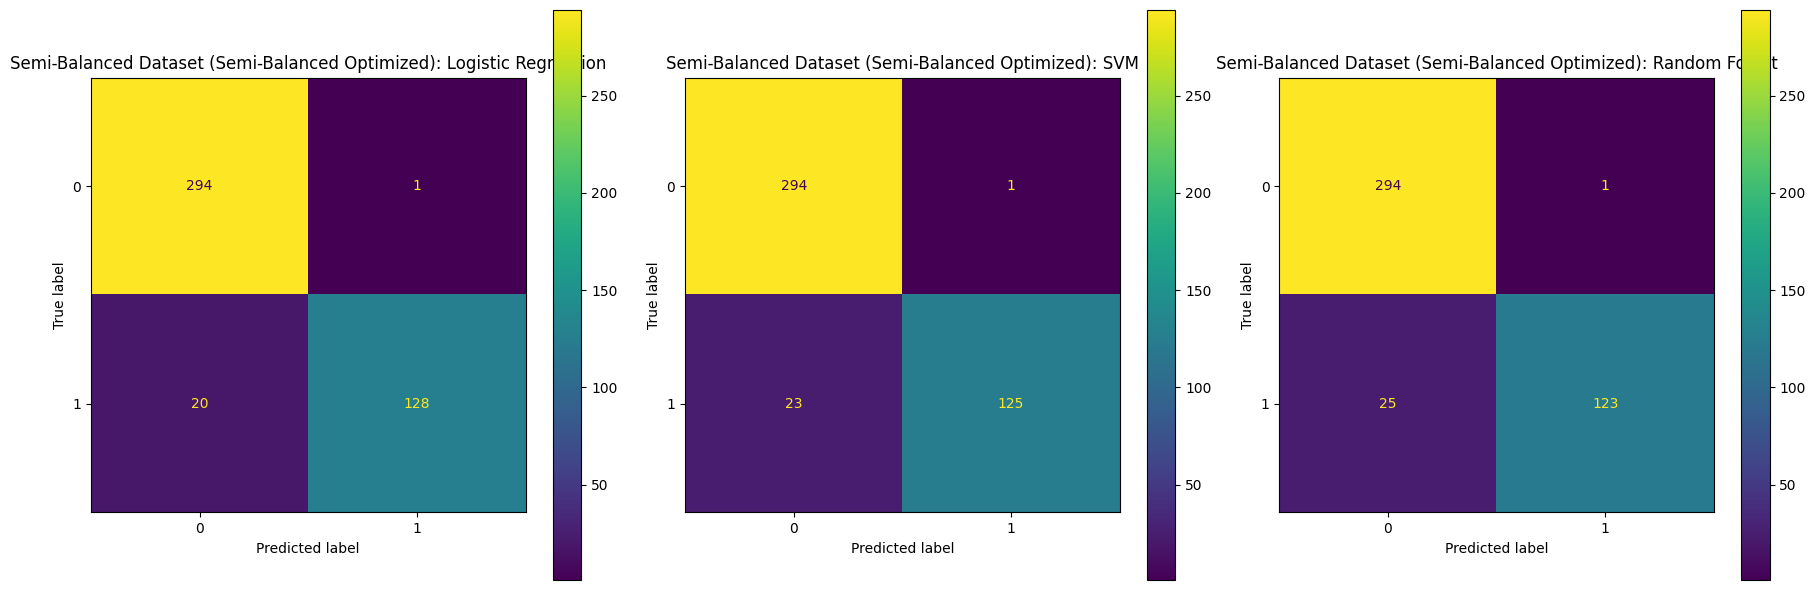

In [46]:
# Function to plot confusion matrices side by side
def plot_confusion_matrices_side_by_side(confusion_matrices, model_names, title_prefix):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create a 1x3 grid of subplots
    for i, (cm, model_name) in enumerate(zip(confusion_matrices, model_names)):
        ax = axes[i]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, colorbar=True)  # Disable colorbar for uniform appearance
        ax.set_title(f"{title_prefix}: {model_name}")
    plt.tight_layout()
    plt.show()

# Model names
model_names = ["Logistic Regression", "SVM", "Random Forest"]

# Plot confusion matrices for balanced models balanced optimized
plot_confusion_matrices_side_by_side(CMs_balanced, model_names, "Balanced Dataset (Balanced Optimized)")

# Plot confusion matrices for balanced models semi-balanced optimized
plot_confusion_matrices_side_by_side(CMs_balanced_smodels, model_names, "Balanced Dataset (Semi-Balanced Optimized)")

# Plot confusion matrices for unbalanced models balanced optimized
plot_confusion_matrices_side_by_side(CMs_unbalanced, model_names, "Unbalanced Dataset (Balanced Optimized)")

# Plot confusion matrices for unbalanced models semi-balanced optimized
plot_confusion_matrices_side_by_side(CMs_unbalanced_smodels, model_names, "Unbalanced Dataset (Semi-Balanced Optimized)")

# Plot confusion matrices for semi-balanced models balanced optimized
plot_confusion_matrices_side_by_side(CMs_semi_balanced, model_names, "Semi-Balanced Dataset (Balanced Optimized)")

# Plot confusion matrices for semi-balanced models semi-balanced optimized
plot_confusion_matrices_side_by_side(CMs_semi_balanced_smodels, model_names, "Semi-Balanced Dataset (Semi-Balanced Optimized)")




## Create ROC Curves To Visualize Model Performance

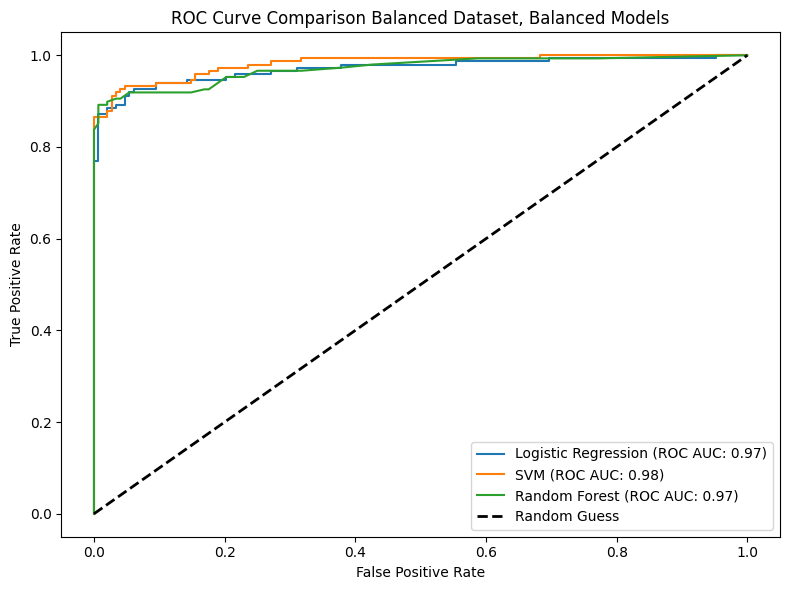

In [31]:
# This code should be placed after the chunk creating the dataframes if the commented out portion below is to be added
# Plot ROC curves
plt.figure(figsize=(8, 6))
for name, roc_data in roc_curves_balanced:
    if roc_data is not None:
        fpr, tpr, _ = roc_data
        plt.plot(fpr, tpr, label=f"{name} (ROC AUC: {balanced_results_df.loc[balanced_results_df['Model'] == name, 'ROC AUC'].values[0]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2, label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison Balanced Dataset, Balanced Models")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

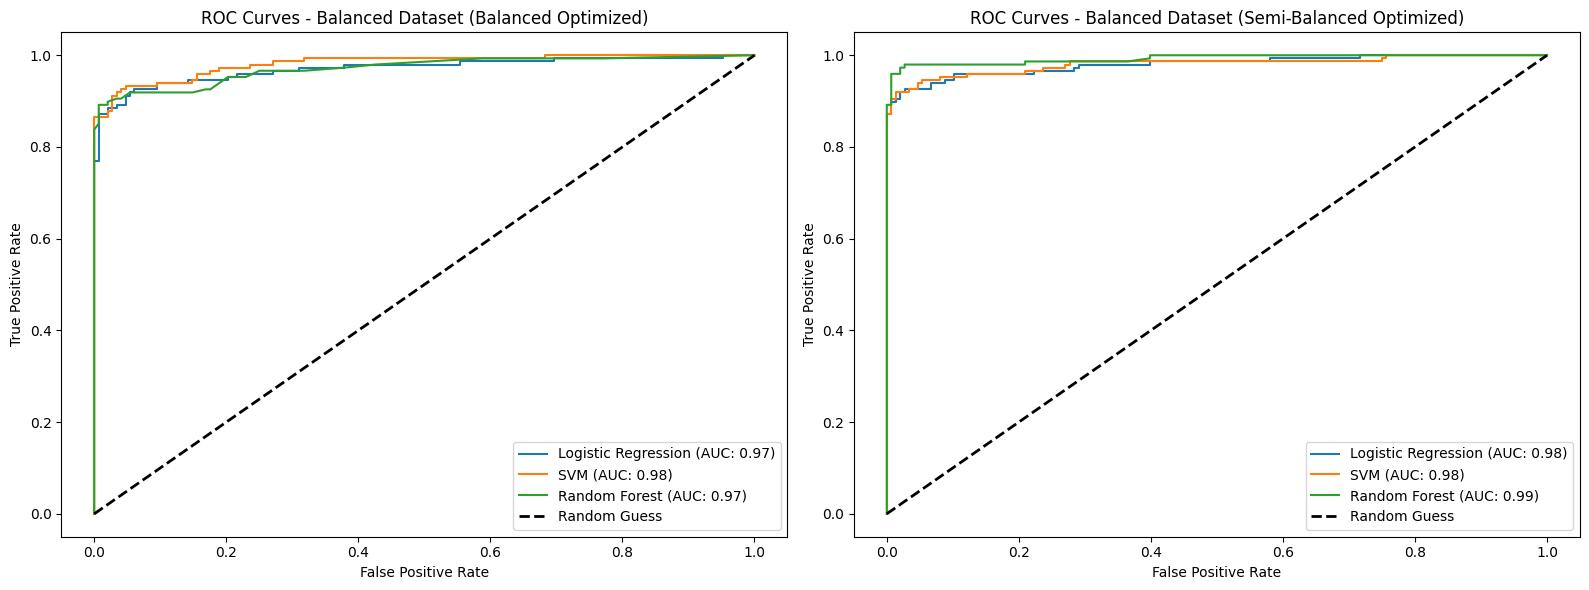

In [37]:
def plot_roc_curves(roc_curves, result_df, title, ax):
    # Create subplots for side-by-side ROC curves
    for name, roc_data in roc_curves:
        if roc_data is not None:
            fpr, tpr, _ = roc_data
            ax.plot(fpr, tpr, label=f"{name} (AUC: {result_df.loc[result_df['Model'] == name, 'ROC AUC'].values[0]:.2f})")
    ax.plot([0, 1], [0, 1], "k--", lw=2, label="Random Guess")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")


# Create subplots for side-by-side ROC curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot ROC curves for balanced models
plot_roc_curves(roc_curves_balanced, balanced_results_df, "ROC Curves - Balanced Dataset (Balanced Optimized)", axes[0])

# Plot ROC curves for semi-balanced optimized models
plot_roc_curves(roc_curves_balanced_smodels, balanced_results_smodels_df,"ROC Curves - Balanced Dataset (Semi-Balanced Optimized)", axes[1])

# Adjust layout
plt.tight_layout()
plt.show()

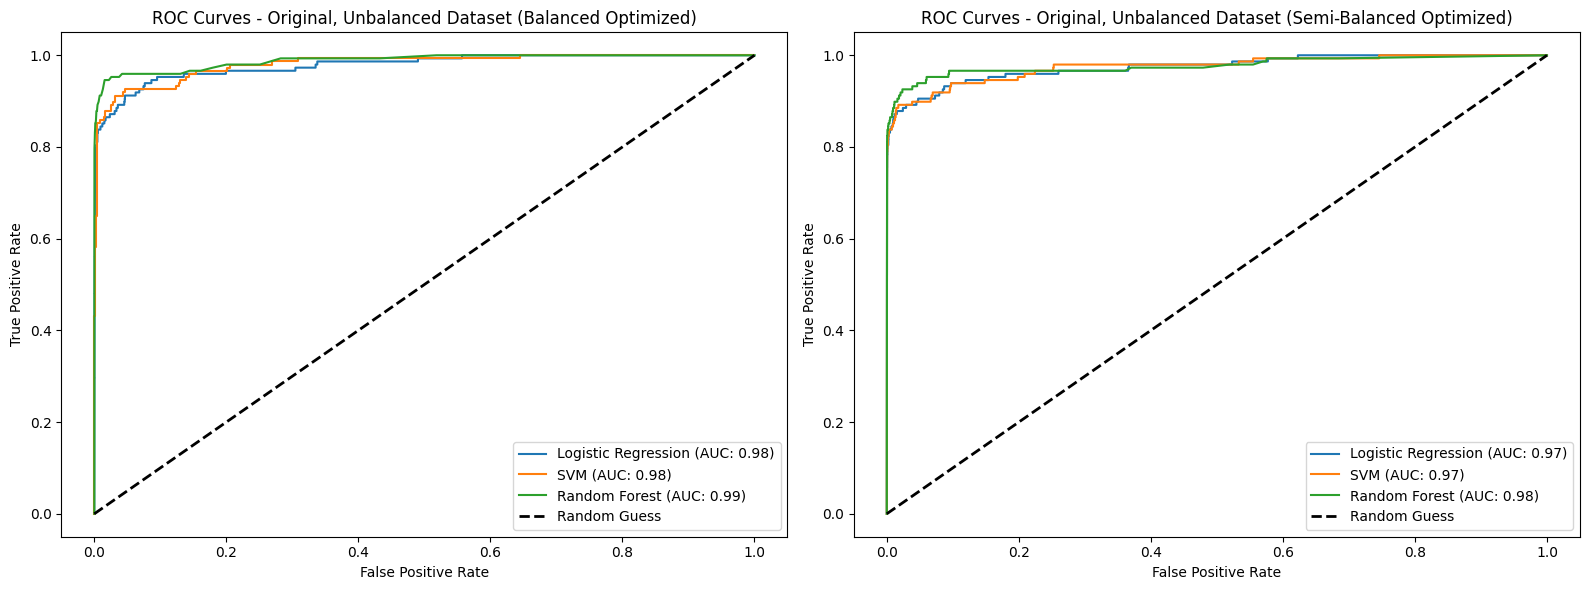

In [38]:
# Create subplots for side-by-side ROC curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot ROC curves for balanced models
plot_roc_curves(roc_curves_unbalanced, original_results_df, "ROC Curves - Original, Unbalanced Dataset (Balanced Optimized)", axes[0])

# Plot ROC curves for semi-balanced optimized models
plot_roc_curves(roc_curves_unbalanced_smodels, original_results_smodels_df,"ROC Curves - Original, Unbalanced Dataset (Semi-Balanced Optimized)", axes[1])

# Adjust layout
plt.tight_layout()
plt.show()

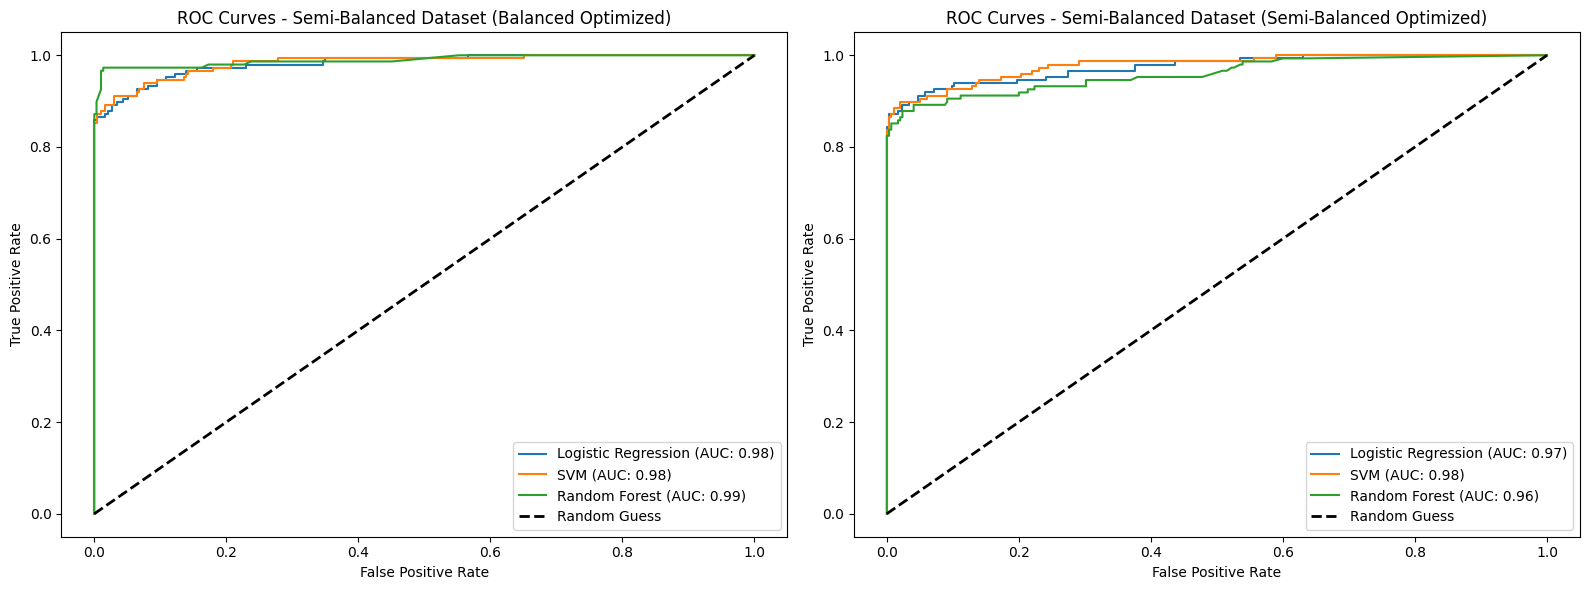

In [39]:
# Create subplots for side-by-side ROC curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot ROC curves for balanced models
plot_roc_curves(roc_curves_semi_balanced, semi_balanced_results_df, "ROC Curves - Semi-Balanced Dataset (Balanced Optimized)", axes[0])

# Plot ROC curves for semi-balanced optimized models
plot_roc_curves(roc_curves_semi_balanced_smodels, semi_balanced_results_smodels_df,"ROC Curves - Semi-Balanced Dataset (Semi-Balanced Optimized)", axes[1])

# Adjust layout
plt.tight_layout()
plt.show()

## Create Grouped Bar Plots to Visualize Model Performance

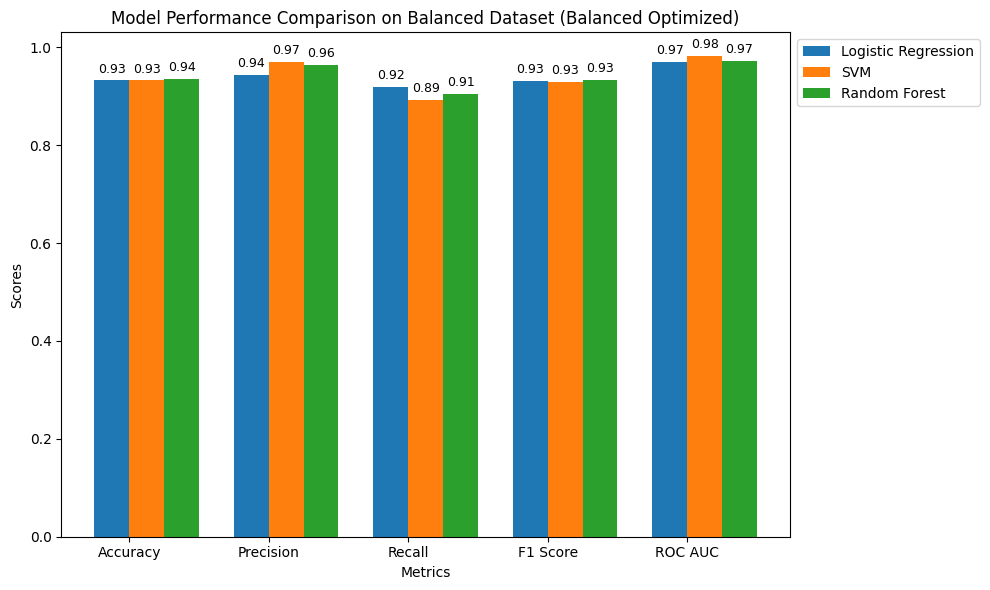

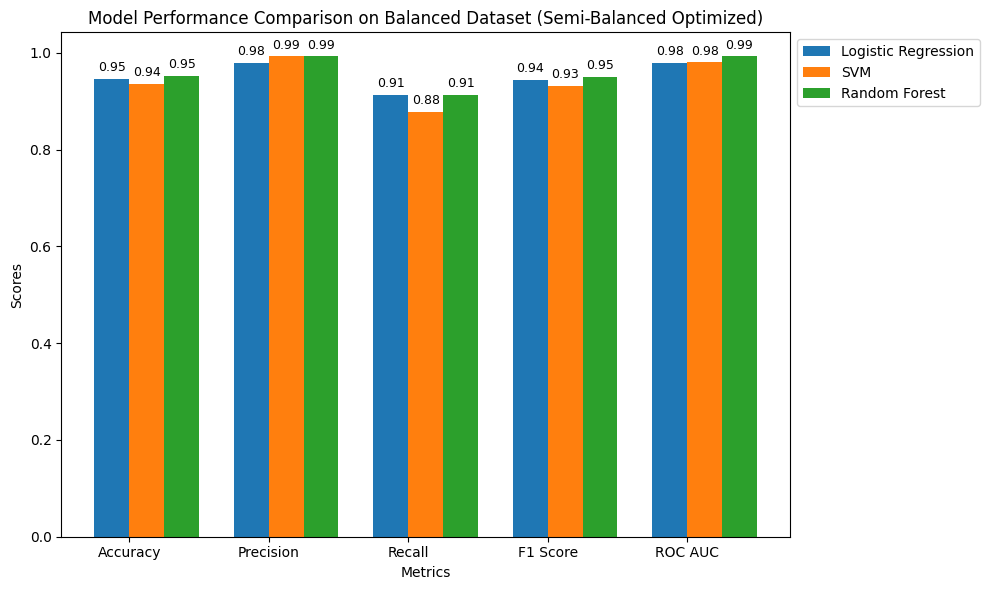

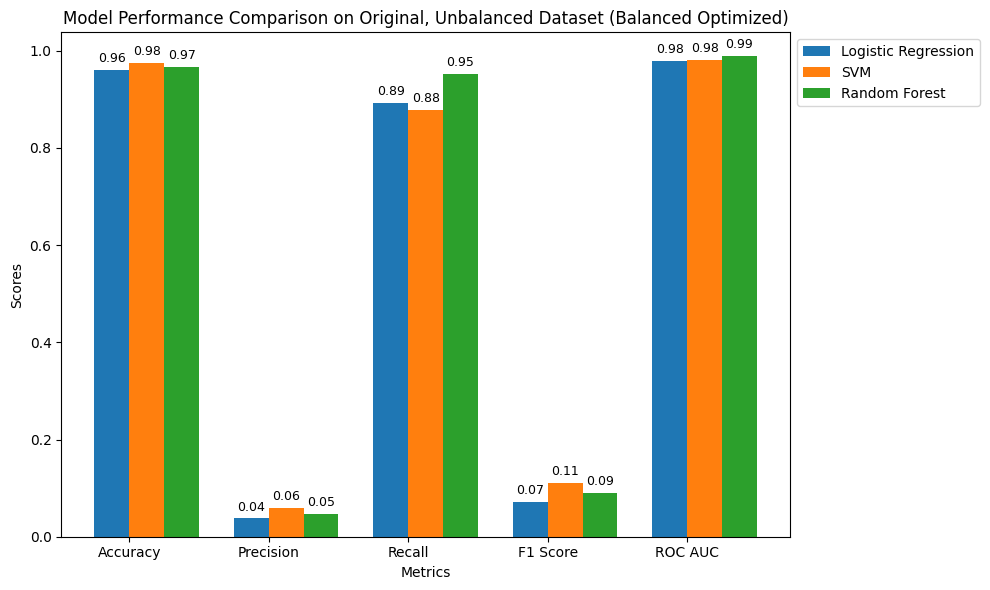

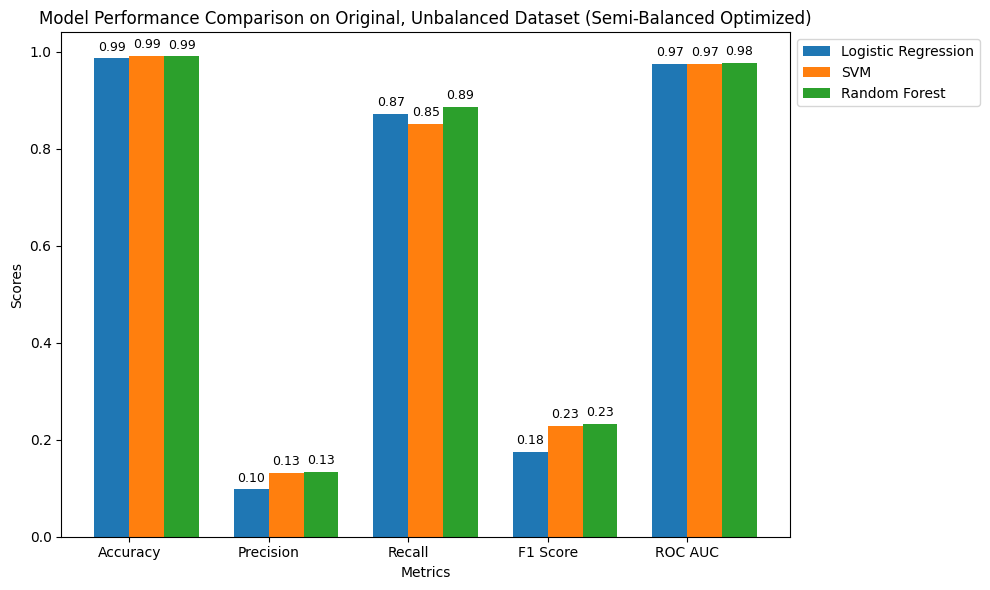

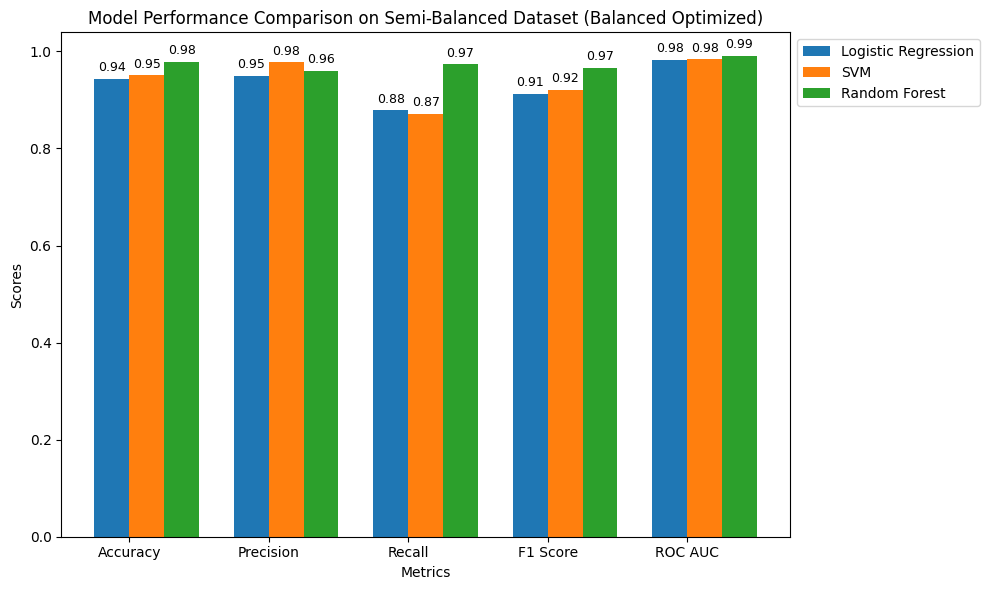

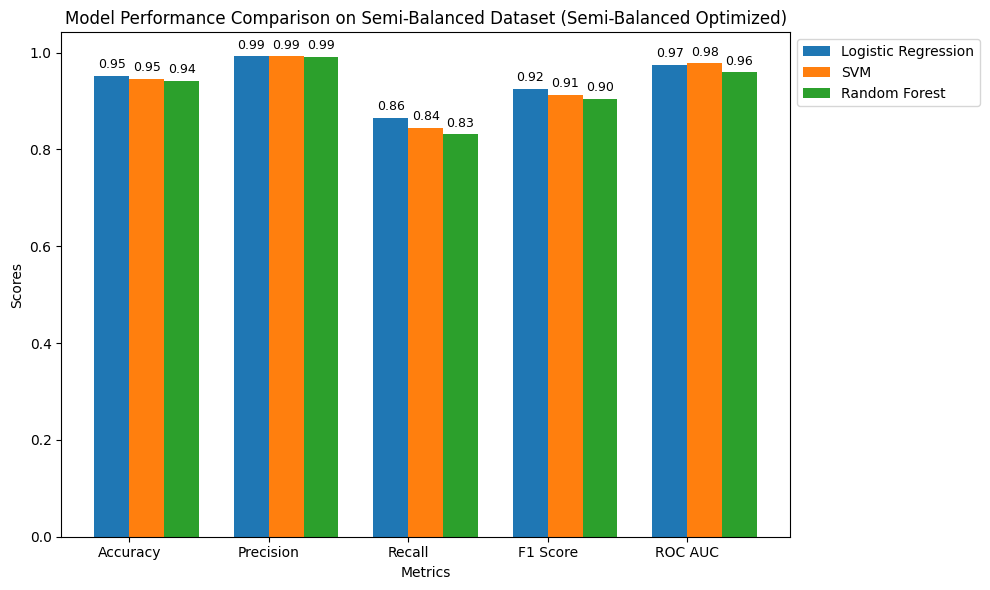

In [45]:

def plot_grouped_barplot(results_df, title, metrics=["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]):
    """
    Function to create a grouped bar plot for model performance metrics with numeric values on top of each bar.
    
    Parameters:
    - results_df: DataFrame containing the performance metrics.
    - title: Title of the plot.
    - metrics: List of metrics to include on the x-axis.
    """
    model_names = results_df["Model"]
    data = results_df[metrics].values.T  # Transpose to organize metrics for plotting

    # Configuration for the plot
    x = np.arange(len(metrics))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting each group of bars
    for i, (model_name, model_data) in enumerate(zip(model_names, data.T)):
        bars = ax.bar(x + i * width, model_data, width, label=model_name)

        # Add numeric values on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # Center the text horizontally
                height + 0.01,  # Slightly above the top of the bar
                f'{height:.2f}',  # Format to 2 decimal places
                ha='center',  # Horizontal alignment
                va='bottom',  # Vertical alignment
                fontsize=9  # Font size for the numbers
            )

    # Customizing the plot
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Scores")
    ax.set_title(title)
    ax.set_xticks(x + width / 2)  # Adjust to center the ticks
    ax.set_xticklabels(metrics)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Display the plot
    plt.tight_layout()
    plt.show()

# Generate grouped bar plots for both balanced and semi-balanced results
plot_grouped_barplot(balanced_results_df, "Model Performance Comparison on Balanced Dataset (Balanced Optimized)")
plot_grouped_barplot(balanced_results_smodels_df, "Model Performance Comparison on Balanced Dataset (Semi-Balanced Optimized)")

plot_grouped_barplot(original_results_df, "Model Performance Comparison on Original, Unbalanced Dataset (Balanced Optimized)")
plot_grouped_barplot(original_results_smodels_df, "Model Performance Comparison on Original, Unbalanced Dataset (Semi-Balanced Optimized)")

plot_grouped_barplot(semi_balanced_results_df, "Model Performance Comparison on Semi-Balanced Dataset (Balanced Optimized)")
plot_grouped_barplot(semi_balanced_results_smodels_df, "Model Performance Comparison on Semi-Balanced Dataset (Semi-Balanced Optimized)")